In [1]:
#import some liberaries needed in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

In [2]:
#get the data and save it to data variable
data = pd.read_csv('E:/SaMeH/Handsa/Machine Learning Nanodegree/Datasets/appdata10.csv')

data.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [3]:
#Get inuttion about the dataset dtypes and detect null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
user                    50000 non-null int64
first_open              50000 non-null object
dayofweek               50000 non-null int64
hour                    50000 non-null object
age                     50000 non-null int64
screen_list             50000 non-null object
numscreens              50000 non-null int64
minigame                50000 non-null int64
used_premium_feature    50000 non-null int64
enrolled                50000 non-null int64
enrolled_date           31074 non-null object
liked                   50000 non-null int64
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


In [4]:
#Get inuttion about the dataset statistics
data.describe()

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


**Conclusion:**
* As we see from `info` function the `enrolled_date` feature has null values that we have to take care of.
* Tthere also some categorical features that need to be pre-pocessed

---

---
# Apply Feature Engineering

In the next section I'll do some Feature Engineering in order to extract more valueable features hidden in the current features. So here is these features that need **`Feature Engineering`**
* `hour`,
* `first_open`,  
* `screen_list`,

In [5]:
# copy the dataset first
new_data = data.copy()

# Get the hour
hour = new_data['hour'].str.slice(0, 3).astype(int)

# replace the old hour column by the new one
new_data['hour'] = hour

In [6]:
# get the date only from first_open column
first_open_date = new_data['first_open'].str.slice(0, 10)

# replace the old first_open column by the new one
new_data['first_open'] = first_open_date

#Extract the first open year and month
first_open_year = new_data['first_open'].str.slice(0, 4).astype(int)
first_open_month = new_data['first_open'].str.slice(5, 7).astype(int)

new_data['first_open_year'] = first_open_year
new_data['first_open_month'] = first_open_month

In [7]:
#Now I'll extract many features from screen_list feature and apply One_Hot_Encoding
#I'm not going to work with the screens associated with this dataset, 
#instead I'm going to work with the most frequently used screens.

#load the most frquently used screens and compare them to overall screens
top_screens = pd.read_csv('E:/SaMeH/Handsa/Machine Learning Nanodegree/Datasets/top_screens.csv')

#Get the values from the top_screens
top_scr = top_screens['top_screens'].values

#print the number of Features before extracting the screen_list feature
print("Number of Features before extracting the screen_list feature is: {}".format(new_data.shape[1]))

for screen in top_scr:
    new_data[screen] = data['screen_list'].str.contains(screen).astype(int)

#drop the column of screen_list from new_data
new_data.drop(['screen_list', 'user'], axis = 1, inplace = True)

print("There is {} frequently used screens".format(len(top_screens)))
print("Number of Features after extracting the screen_list feature is: {}".format(new_data.shape[1]))

Number of Features before extracting the screen_list feature is: 14
There is 58 frequently used screens
Number of Features after extracting the screen_list feature is: 70


**NOTE:** I'm going to test what is the most effective screens that attached with the customer enrollment, so after building the model on the hole screens I'll test on the most effective screens and see the difference.

In [8]:
#Save the best screens on best_screens
best_screens = {}

#iterate over all the screens to see the best
for screen in top_scr:
    s = new_data.groupby(screen).count()['enrolled']
    if len(s) > 1:
        if (s.iloc[0] <= s.iloc[1]):
            best_screens[screen] = s.iloc[1]
print("There is {} Best Screens:".format(len(best_screens)))
best_screens

There is 4 Best Screens:


{'Loan2': 25319, 'location': 25888, 'VerifyPhone': 26230, 'Loan': 32771}

Let's take only the numeric values in separate dataset to plot `Histograms`

In [9]:
numeric_attr = ['dayofweek', 'hour', 'numscreens', 'minigame','age',
                'used_premium_feature', 'enrolled', 'liked', 
                'first_open_year', 'first_open_month']

numeric_data = new_data[numeric_attr]

numeric_data.head()

,dayofweek,hour,numscreens,minigame,age,used_premium_feature,enrolled,liked,first_open_year,first_open_month
0,3,2,15,0,23,0,0,0,2012,12
1,6,1,13,0,24,0,0,0,2012,12
2,1,19,3,0,23,1,0,1,2013,3
3,4,16,40,0,28,0,1,0,2013,7
4,1,18,32,0,31,0,1,1,2013,2


# Correlation Testing, Gain Insight  
In the following section I'm going to plot histograms and correlation matrix and apply some technequies to complete the `Feature Engineering` process and keep the most important features

Firstly, I'll plot Histograms to see the distribution of the numeric data. 

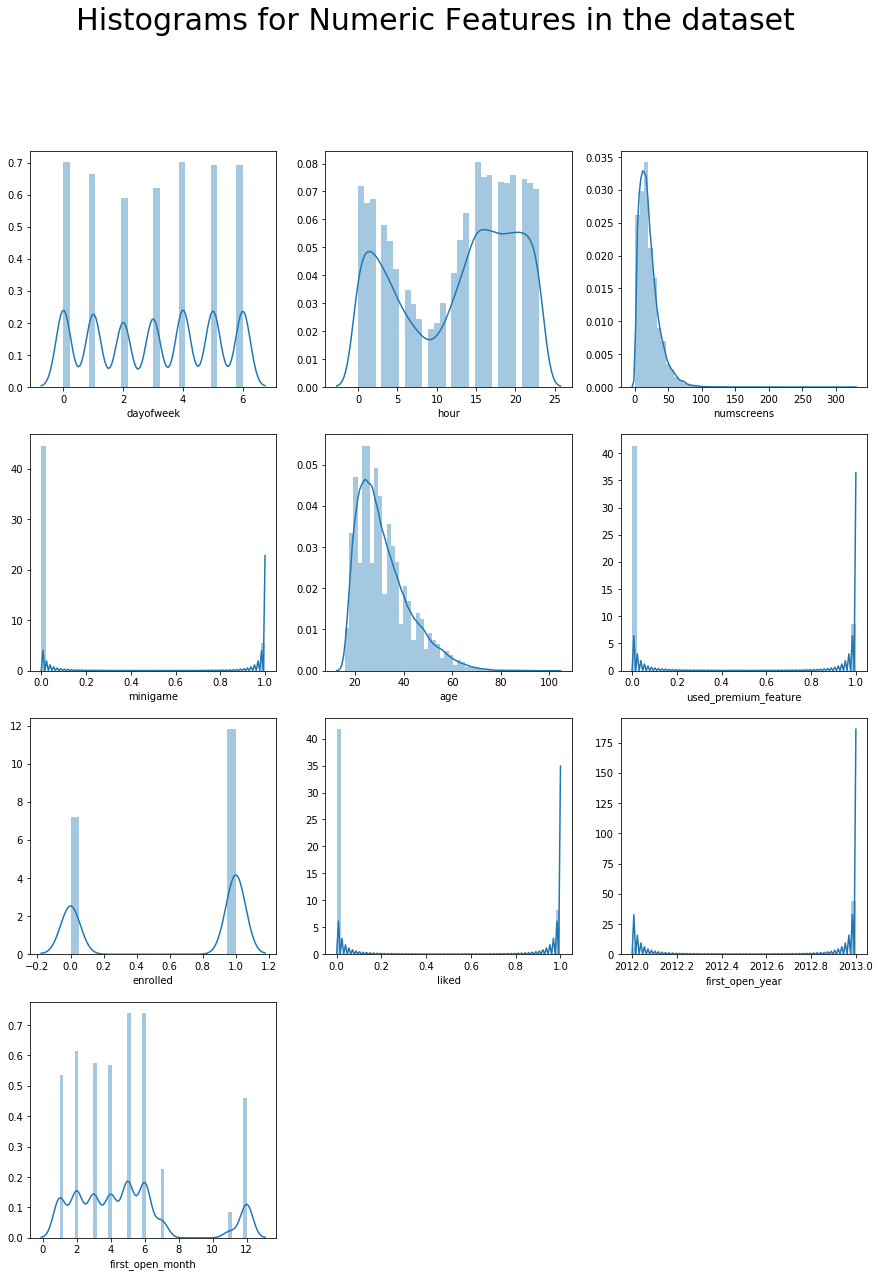

In [10]:
plt.figure(figsize = (15, 20))
plt.suptitle('Histograms for Numeric Features in the dataset', fontsize = 30)
L = list(numeric_data)
for i in range(numeric_data.shape[1]):
    plt.subplot(4, 3, i + 1)
    sns.distplot(numeric_data[L[i]])

**Let's Examine the correlation between the features and the target feature `enrolled`**

In [11]:
corr = numeric_data.corr()['enrolled'].sort_values(ascending = False)

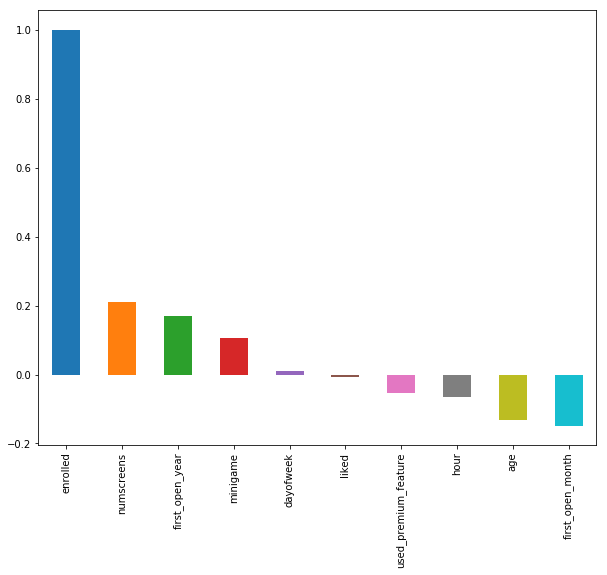

In [12]:
# plot barplot to gain intution about the relation between the features and the target
corr.plot.bar(figsize=(10,8))
plt.show()

**NOTE:** From the following Heatmap and correlation matrix we have to be careful and notice if there is a relation between the individual features?

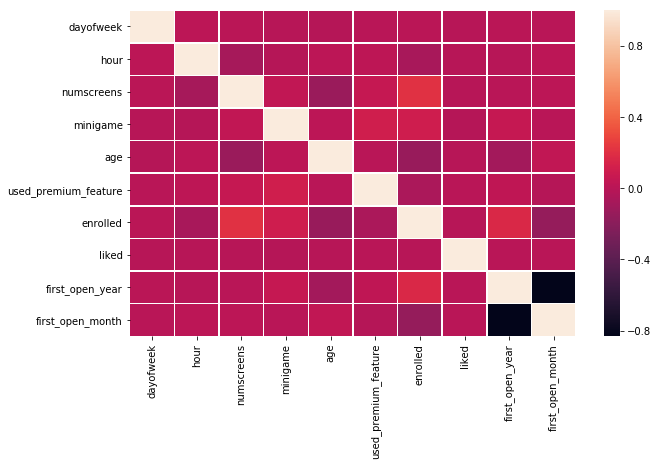

In [13]:
#Plot Heatmap to gain insights about the relations between all the features
plt.figure(figsize = (10, 6))
sns.heatmap(numeric_data.corr(), linewidth = 0.5)
plt.show()

**Conclusion:** From the correlation matrix and the heatmap above there some features that the target (enrolled) related to, and there is no dependence between the features. So the features that we have to keep with us from the numeric dataset are the following:
1. numscreens
* first_open_year
* minigame
* first_open_month
* age


---
* **Now we know the best numeric features that exist in the dataset so we are going to save them, and work only with them.**
* **Split the dataset into `features` and `target`**
* **Split the data to `trainset` and `testset`**
* **Transform the dataset using sklearn**

In [14]:
# Save the most important numeric features in attr variable
best_numeric_attr = ['numscreens', 'first_open_year', 'minigame', 'first_open_month', 'age']

#Concatenate both the numeric and categorical datasets in final_data variable
final_data = pd.concat([numeric_data[best_numeric_attr], new_data[top_scr]], axis = 1)

#target variable is enrolled 
target = numeric_data['enrolled']

print("Number of features in the final dataset is: {}".format(final_data.shape[1]))

Number of features in the final dataset is: 63


Now it is the time to transform the dataset. Transforming the data to make sure the features have the same range, and ensure they all have `Normal Distribution`
- Use StandardScalar from sklearn 

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

#fit transfofrm the data 
transformed_data = scaler.fit_transform(final_data)

In [16]:
# import train_test_split liberary
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(transformed_data, target, 
                                                    test_size = 0.2,
                                                    random_state = 0)

print("X_Trainset size is: {}, and X_Testset size is: {}".format(X_train.shape, X_test.shape))

X_Trainset size is: (40000, 63), and X_Testset size is: (10000, 63)


# Build Model and Measure Accuracy

**This section will apply the following:**
* I'm going to select some `classification` algorithms.
* Measure `Accuracy` of these models.
* Build `Learning Curves` to detect overfitting and underfitting.
* Fine Tune the final model's `hyper-parameter`.

In [17]:
#import the classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
#from sklearn.neighbors import KNeighborsClassifier

#Define the algorithms
deciosion_tree = DecisionTreeClassifier(random_state = 0)
random_forest = RandomForestClassifier(random_state = 0)
logisitc = LogisticRegression(random_state = 0)
naive = GaussianNB()

estimators = [deciosion_tree, random_forest, logisitc, naive]

1.Work on **DecisionTreeClassifier**:
* Fit
* Predict
* Measure Accuracy

**From functions file I'll use measure_accuracy function to measure accuracies for initial selected estimators**

In [18]:
#import functions file
from functions import measure_accuracy

#measure accuracies for selected estimators
measure_accuracy(estimators, X_train, y_train)

DecisionTreeClassifier: f1_score: 0.9942374183634267, Accuracy_score: 0.992875 


RandomForestClassifier: f1_score: 0.9834976815761233, Accuracy_score: 0.979625 


LogisticRegression: f1_score: 0.8104611367188272, Accuracy_score: 0.760475 


GaussianNB: f1_score: 0.6724225741517716, Accuracy_score: 0.662325 




**Now I'm going to plot Learning curves for these estimators to see which will `overfit` and which will `underfit` and which will perform `just good`.**

Precentage of work done: 25.0%
Precentage of work done: 50.0%
Precentage of work done: 75.0%
Precentage of work done: 100.0%


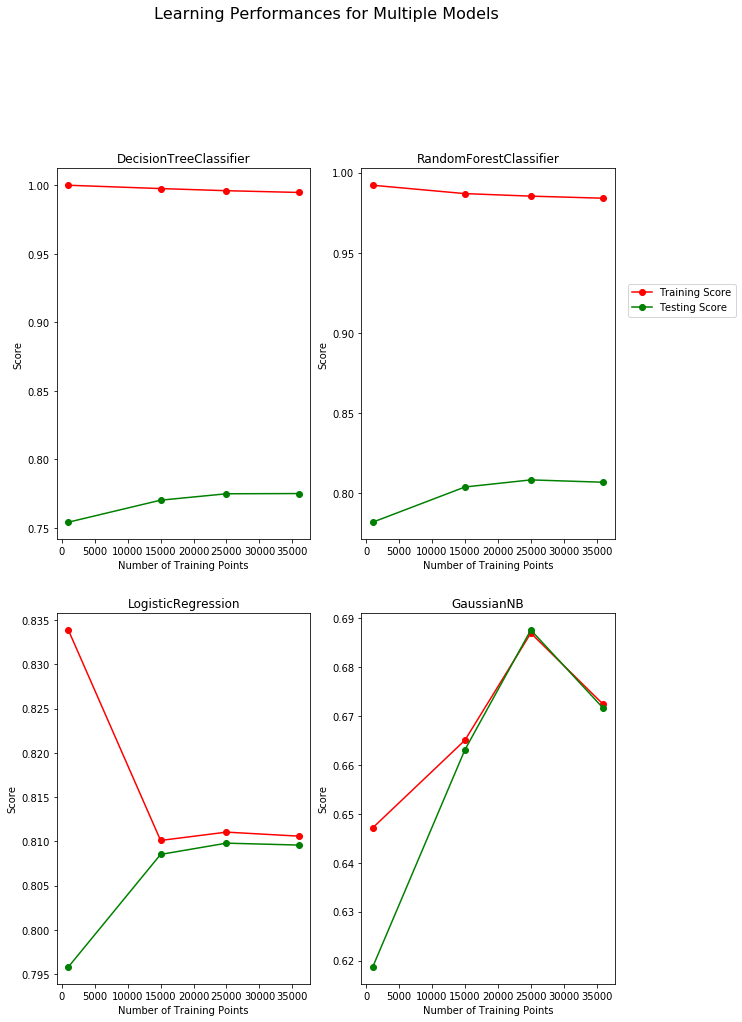

In [20]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score
from functions import plot_learning_curve

#define the training sizes for the learning curve 
train_sizes = [1000, 15000, 25000, 36000]

# make 10 folds to apply cross-validation inside learning curve function 
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)

#define a scorer upon which we measure the accuracy
scorer = make_scorer(f1_score)

plot_learning_curve(estimators, X_train, y_train, train_sizes, scorer, cv)
